In [166]:
import os
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [156]:
no_real_disater = 0
real_disaster = 1

no_real_disaster_label = "no_real_disaster"
real_disaster_label = "real_disaster"

target_names = ["Not real disaster", "Real disaster"]

target_dict = {
    "label": target_names,
    "value": [0, 1]
}
target_df = pd.DataFrame(target_dict)

original_columns = ["id", "keyword", "location", "text", "target"]

stop_words = stopwords.words('english')

### Data folders

In [182]:
data_folder = "data"
submissions_folder = os.path.join(data_folder, "submissions") 

train_file = os.path.join(data_folder, "train.csv")
test_file = os.path.join(data_folder, "test.csv")

### Data analysis

In [91]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)


# Adding target labels
train_df.loc[:, "target_str"] = pd.merge(train_df, target_df, how="left", left_on="target", right_on="value")["label"]

train_df.head()

,id,keyword,location,text,target,target_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


In [92]:
print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (7613, 6)
Test size: (3263, 4)


In [93]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   target_str  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


#### Convert to string type

In [94]:
string_columns = ["keyword", "location", "text", "target_str"]
train_df.loc[:, string_columns] = train_df[string_columns].astype("string")

In [95]:
train_df.head()

,id,keyword,location,text,target,target_str
0,1,<NA>,<NA>,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,<NA>,<NA>,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,<NA>,<NA>,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,<NA>,<NA>,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,<NA>,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


#### NaNs vs NO NaNs by column

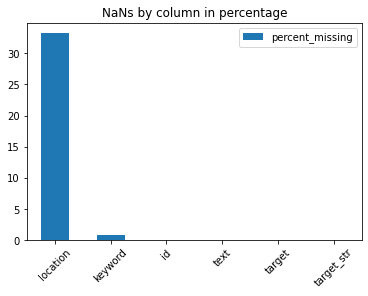

In [96]:
percent_missing = train_df.isnull().sum() * 100 / train_df.shape[0]
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})

missing_value_df.sort_values(by="percent_missing", ascending=False).plot(
    kind="bar", title="NaNs by column in percentage", rot=45)

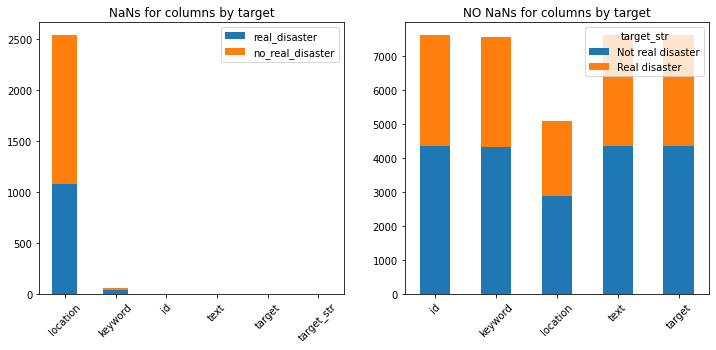

In [97]:
no_nan_df = train_df.groupby("target_str").count().transpose()

cond_disaster = train_df.target == real_disaster
nan_df = pd.concat([train_df[cond_disaster].isnull().sum(),
                    train_df[~cond_disaster].isnull().sum()], axis=1)
nan_df.columns = [real_disaster_label, no_real_disaster_label]
nan_df.sort_values(by=[real_disaster_label], ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 5))

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

nan_df.plot(kind="bar", stacked=True, title="NaNs for columns by target", ax=ax1, rot=45)
no_nan_df.plot(kind="bar", stacked=True, title="NO NaNs for columns by target", ax=ax2, rot=45)

#### Keyword

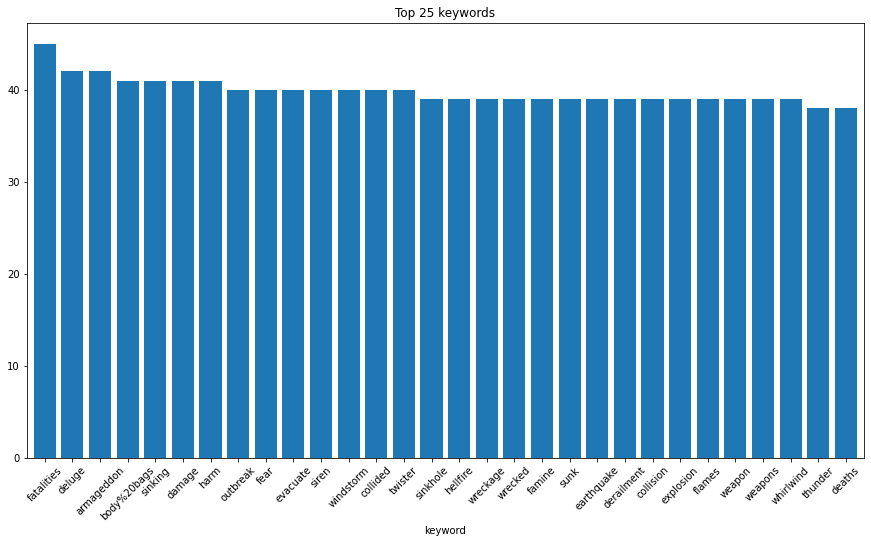

In [98]:
train_df.groupby("keyword").size().sort_values(ascending=False)[:30].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 keywords", rot=45)

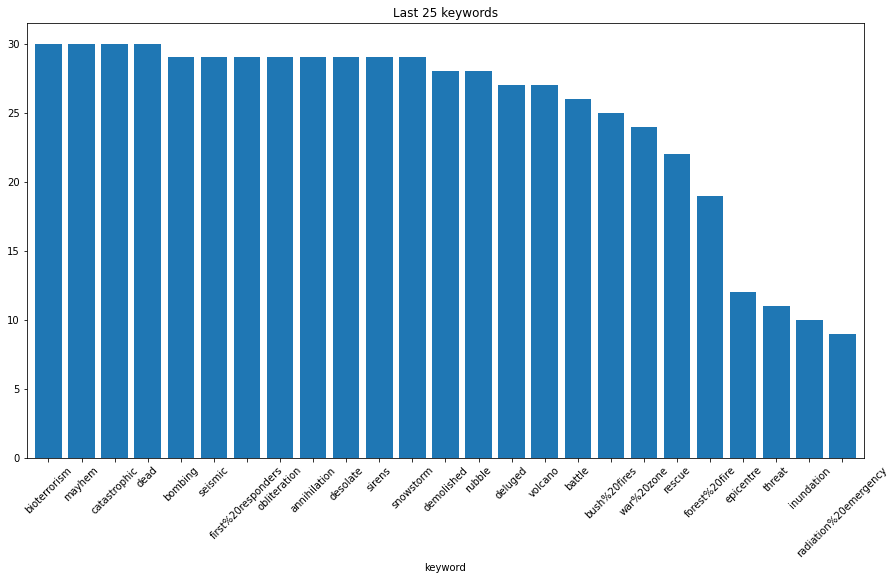

In [99]:
train_df.groupby("keyword").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 keywords", rot=45)

#### Location

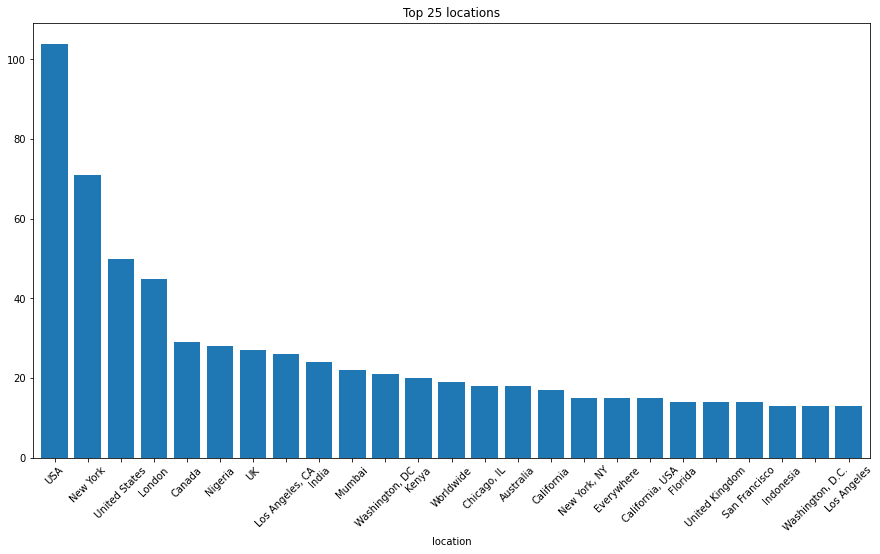

In [100]:
train_df.groupby("location").size().sort_values(ascending=False)[:25].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 locations", rot=45)

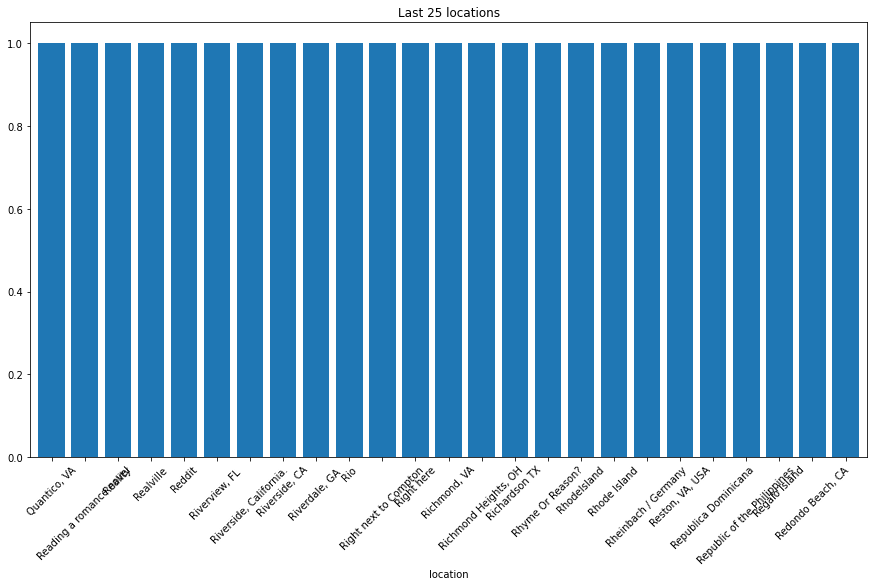

In [101]:
train_df.groupby("location").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 locations", rot=45)

#### Target

(-1.25, 1.25, -1.25, 1.25)

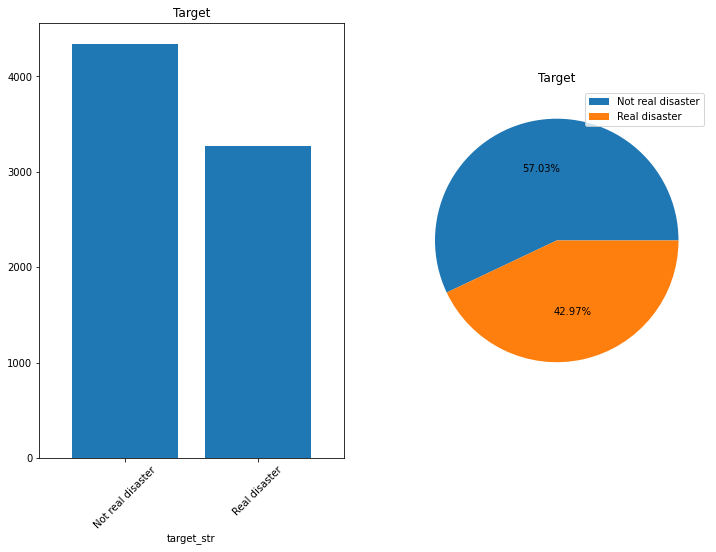

In [102]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, legend=True, autopct="%.2f%%", labels=None)

ax2.axis("off")

### Text

Choose randomly 5 tweets for visualize text content

In [103]:
for tweet, keyword, label in train_df[["text", "keyword", "target_str"]].sample(n=5).values:
    print(f"{keyword}\n{tweet}\n{label}\n")

blight
Locksmithing-art respecting elaboration only blight locks: lPDkl
Not real disaster

body%20bags
Fairfax investigating firefighter over Facebook post saying police should be put in Û÷body bagsÛª - The Washington Post http://t.co/jAxHzjCCd4
Not real disaster

rioting
.@runjewels recently met with the @BBC to discuss race relations in America &amp; the benefits of rioting. #LoveIsLove 
https://t.co/6Ce1vwOVHs
Not real disaster

quarantined
Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/BjVfk1ETe9
Not real disaster

casualties
#Civilian casualties in Afghanistan hit highest number since 2009 U.N. says via @WashingtonPost - http://t.co/xTF5DvgRvh
Real disaster



In [111]:
# Adding new feature: text_lenght
train_df.loc[:, "text_lenght"] = train_df.text.str.len()

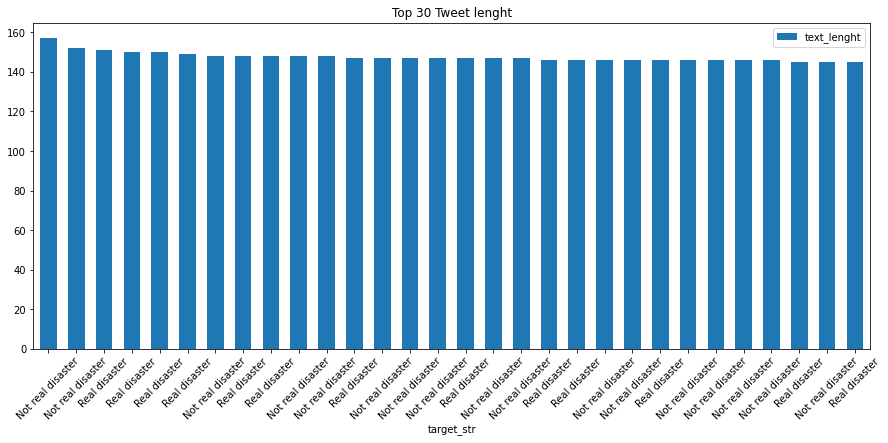

In [112]:
top_len_df = train_df[["text_lenght", "target", "target_str"]].sort_values(
    by="text_lenght", ascending=False).head(30).reset_index(drop=True)
last_len_df = train_df[["text_lenght", "target", "target_str"]].sort_values(
    by="text_lenght", ascending=False).tail(30).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 6))
top_len_df.plot(kind="bar", y="text_lenght", x="target_str", width=0.6, 
                ax=ax, title="Top 30 Tweet lenght", rot=45)

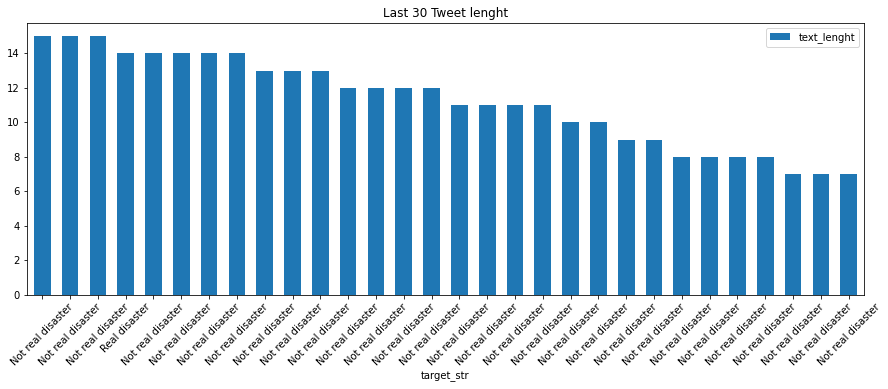

In [113]:
fig, ax = plt.subplots(figsize=(15, 5))
last_len_df.plot(kind="bar", y="text_lenght", x="target_str", width=0.6, 
                ax=ax, title="Last 30 Tweet lenght", rot=45)

In [115]:
def generate_word_frequences_dict(text_list, stop_words):
    # Filter stop words and remove puntuation
    word_list = [word for text in text_list for word in text if word.isalpha() and word not in stop_words]
    return pd.Series(word_list).value_counts().to_dict()

def generate_word_cloud(text_list, title, stop_words=stop_words):
    frequences_dict = generate_word_frequences_dict(text_list, stop_words)
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

In [116]:
def split_text(text, stop_words):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    
    return words

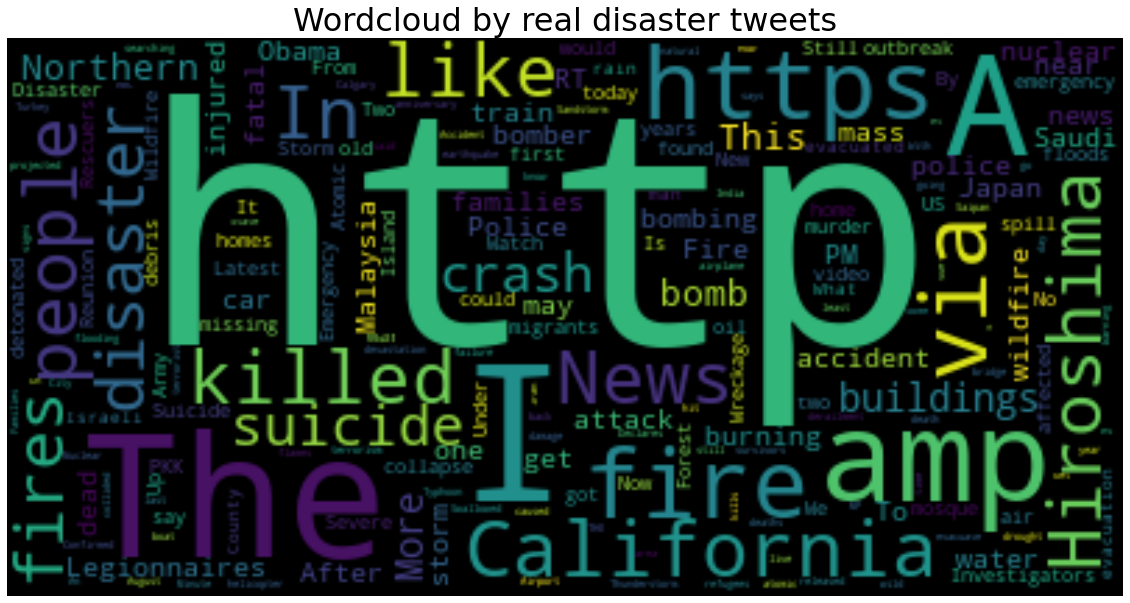

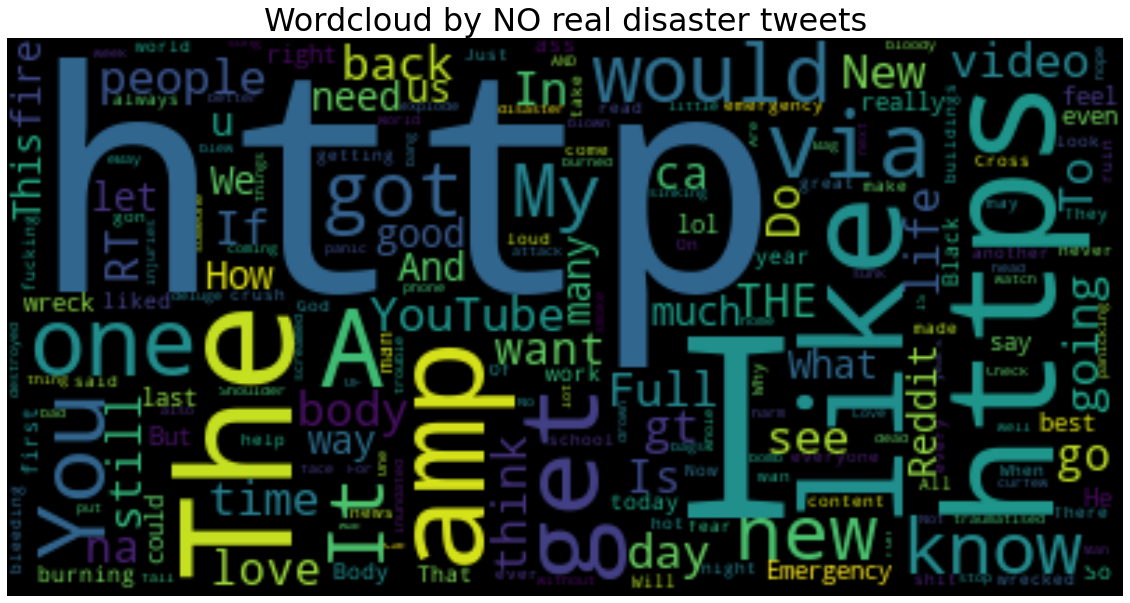

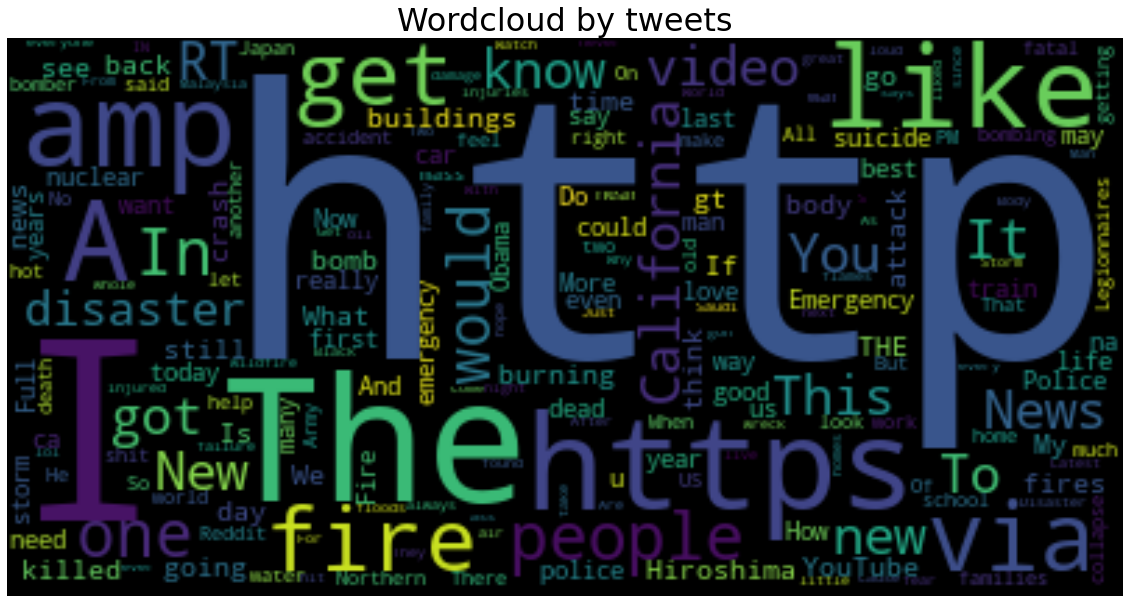

In [117]:
train_df.loc[:, "splited_text"] = train_df["text"].apply(split_text, args=(stop_words,))

generate_word_cloud(train_df[cond_disaster]["splited_text"].values.tolist(), "Wordcloud by real disaster tweets")
generate_word_cloud(train_df[~cond_disaster]["splited_text"].values.tolist(), "Wordcloud by NO real disaster tweets")
generate_word_cloud(train_df["splited_text"].values.tolist(), "Wordcloud by tweets")

### Data cleaning and feature engineering

Remove id column because is not useful

In [118]:
train_df.drop("id", axis=1, inplace=True)

In [119]:
train_df.head()

,keyword,location,text,target,target_str,text_lenght,splited_text
0,<NA>,<NA>,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,"[Our, Deeds, Reason, earthquake, May, ALLAH, F..."
1,<NA>,<NA>,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,<NA>,<NA>,All residents asked to 'shelter in place' are ...,1,Real disaster,133,"[All, residents, asked, place, notified, offic..."
3,<NA>,<NA>,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,"[people, receive, wildfires, evacuation, order..."
4,<NA>,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,"[Just, got, sent, photo, Ruby, Alaska, smoke, ..."


Replace NaN values from keyword and location columns by empty string ("")

In [120]:
train_df.loc[:, ["keyword", "location"]] = train_df[["keyword", "location"]].fillna("")

Create new features based on keyword and location (and previous text_lenght).

In [128]:
train_df.keyword.str.len().astype(bool)

0       False
1       False
2       False
3       False
4       False
        ...  
7608    False
7609    False
7610    False
7611    False
7612    False
Name: keyword, Length: 7613, dtype: bool

In [129]:
train_df.loc[:, "with_keyword"] = train_df.keyword.str.len().astype(bool)
train_df.loc[:, "with_location"] = train_df.location.str.len().astype(bool)

train_df.head()

,keyword,location,text,target,target_str,text_lenght,splited_text,with_keyword,with_location
0,,,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,"[Our, Deeds, Reason, earthquake, May, ALLAH, F...",False,False
1,,,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,"[Forest, fire, near, La, Ronge, Sask, Canada]",False,False
2,,,All residents asked to 'shelter in place' are ...,1,Real disaster,133,"[All, residents, asked, place, notified, offic...",False,False
3,,,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,"[people, receive, wildfires, evacuation, order...",False,False
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,"[Just, got, sent, photo, Ruby, Alaska, smoke, ...",False,False


### Clean tweets content

- Remove puntiation
- Filter stop words
- Stemming

NLTK data url: https://github.com/nltk/nltk_data

Convert tweets to sentences

In [140]:
def text_cleaning(text, stop_words=stop_words):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    return stemmed

In [141]:
train_df.loc[:, "splitted_cleaned_text"] = train_df["text"].apply(text_cleaning, args=(stop_words,))

Choose randomly 5 tweets for visualize text and list of cleaned words

In [142]:
for tweet, cleaned, label in train_df[["text", "splitted_cleaned_text", "target_str"]].sample(n=5).values:
    print(f"{tweet}\n{cleaned}\n{label}\n")

im tired of all these #AllLivesMatter people. they only say this to derail #blacklivesmatter they dont do anything for 'all lives' lmfao
['im', 'tire', 'alllivesmatt', 'peopl', 'say', 'derail', 'blacklivesmatt', 'dont', 'anyth', 'live', 'lmfao']
Not real disaster

#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/fQWTSxLkrZ #prebreak #best
['hot', 'special', 'modifi', 'land', 'stadium', 'rescu', 'hostag', 'iran', 'http', 'prebreak', 'best']
Real disaster

@D1ff3r3nt1sG00d @RiceeChrispies What if he committed a mass murder?
['riceechrispi', 'what', 'commit', 'mass', 'murder']
Real disaster

@blazerfan not everyone can see ignoranceshe is Latinoand that is All she can ever benothing morebut an attack dog 4 a hate group GOP
['blazerfan', 'everyon', 'see', 'ignorancesh', 'latinoand', 'all', 'ever', 'benoth', 'morebut', 'attack', 'dog', 'hate', 'group', 'gop']
Not real disaster

http://t.co/MoA0q0AuFa Jacksonville family bands together as me

### Vectoritzation

In [150]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning)),  # strings to token integer counts
    ("tfidf", TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ("classifier", MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Model Validation

In [171]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.20)
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)

In [172]:
print(classification_report(y_pred, y_test, target_names=target_names))
print(f"Confusion matrix:\n{confusion_matrix(y_pred, y_test)}")
print(f"\nAccuracy: {accuracy_score(y_pred, y_test)}")

                   precision    recall  f1-score   support

Not real disaster       0.89      0.80      0.84       757
    Real disaster       0.67      0.81      0.73       385

         accuracy                           0.80      1142
        macro avg       0.78      0.80      0.79      1142
     weighted avg       0.82      0.80      0.81      1142

Confusion matrix:
[[603 154]
 [ 73 312]]

Accuracy: 0.8012259194395797


#### Prediction and generate kaggle submission

In [173]:
y_pred = pipeline.predict(test_df["text"])

In [192]:
def create_submission_file(predictions, ids, path, filename="submission.csv"):
    submission_data = {
        "id": ids,
        "target": predictions
    }

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(os.path.join(path, filename), index=False)
    
    print("Good luck!")

In [196]:
create_submission_file(y_pred, test_df.id, submissions_folder)

Good luck!


In [134]:
# TODO: Lemmatization